<a href="https://colab.research.google.com/github/kendo58/uni/blob/main/Copy_of_K_Nearest_Neighbors_Classifier_with_Performance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


--- Evaluating Impact of k ---
Training data has been normalized.
k=1: Accuracy=99.00%, Error Rate=1.00%
Training data has been normalized.
k=3: Accuracy=99.00%, Error Rate=1.00%
Training data has been normalized.
k=5: Accuracy=98.75%, Error Rate=1.25%
Training data has been normalized.
k=7: Accuracy=99.00%, Error Rate=1.00%
Training data has been normalized.
k=9: Accuracy=99.50%, Error Rate=0.50%
Training data has been normalized.
k=11: Accuracy=99.50%, Error Rate=0.50%
Training data has been normalized.
k=13: Accuracy=99.25%, Error Rate=0.75%
Training data has been normalized.
k=15: Accuracy=99.50%, Error Rate=0.50%
Training data has been normalized.
k=17: Accuracy=98.25%, Error Rate=1.75%
Training data has been normalized.
k=19: Accuracy=99.00%, Error Rate=1.00%
Training data has been normalized.
k=21: Accuracy=99.75%, Error Rate=0.25%


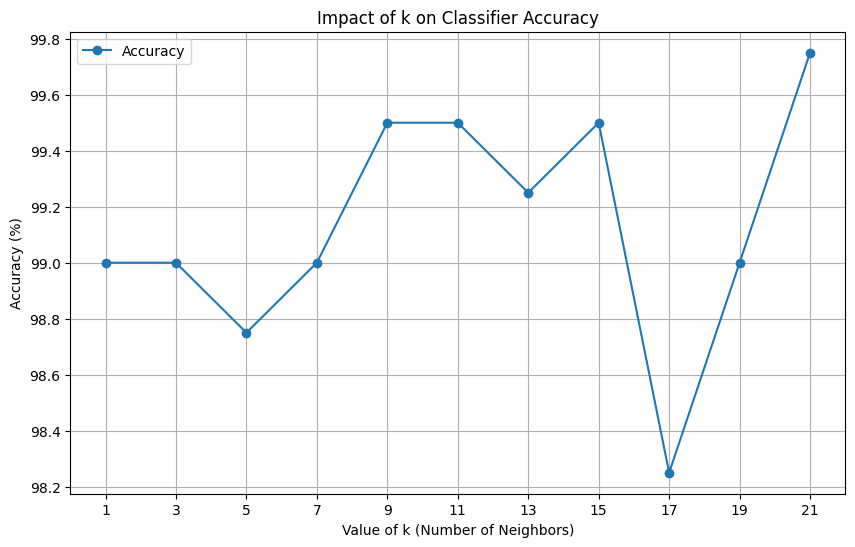

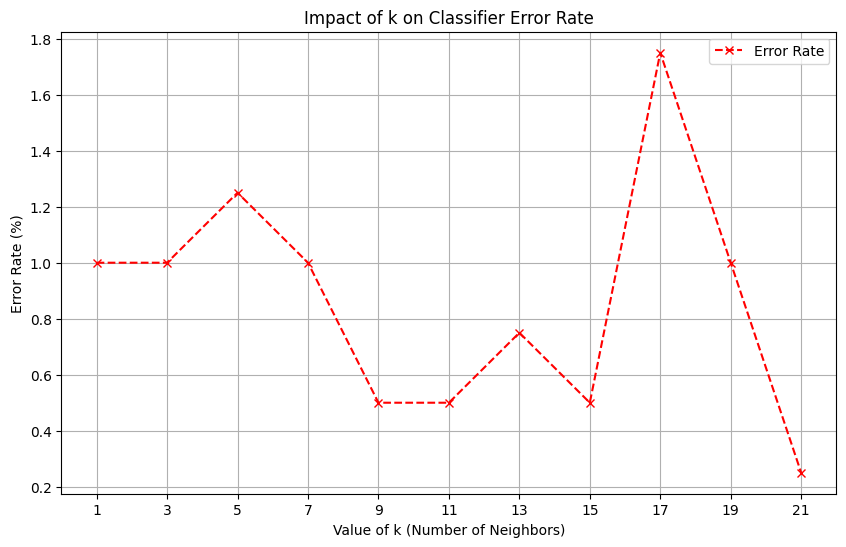


--- Evaluating Impact of Number of Features (j) ---
Training data has been normalized.
j=1 features: Accuracy=79.50%, Error Rate=20.50%
Training data has been normalized.
j=2 features: Accuracy=86.25%, Error Rate=13.75%
Training data has been normalized.
j=3 features: Accuracy=89.75%, Error Rate=10.25%
Training data has been normalized.
j=4 features: Accuracy=94.50%, Error Rate=5.50%
Training data has been normalized.
j=5 features: Accuracy=93.25%, Error Rate=6.75%
Training data has been normalized.
j=6 features: Accuracy=96.50%, Error Rate=3.50%
Training data has been normalized.
j=7 features: Accuracy=97.75%, Error Rate=2.25%
Training data has been normalized.
j=8 features: Accuracy=98.50%, Error Rate=1.50%
Training data has been normalized.
j=9 features: Accuracy=98.75%, Error Rate=1.25%
Training data has been normalized.
j=10 features: Accuracy=98.75%, Error Rate=1.25%
Training data has been normalized.
j=11 features: Accuracy=99.25%, Error Rate=0.75%


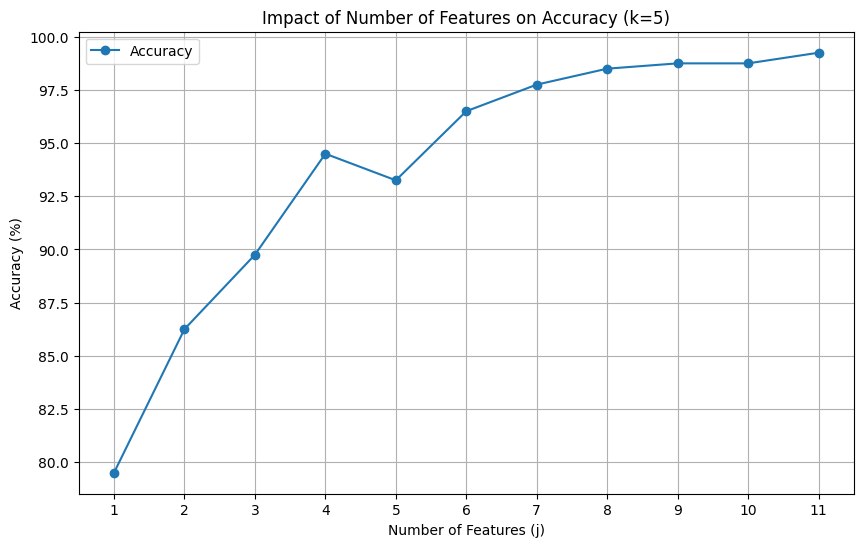

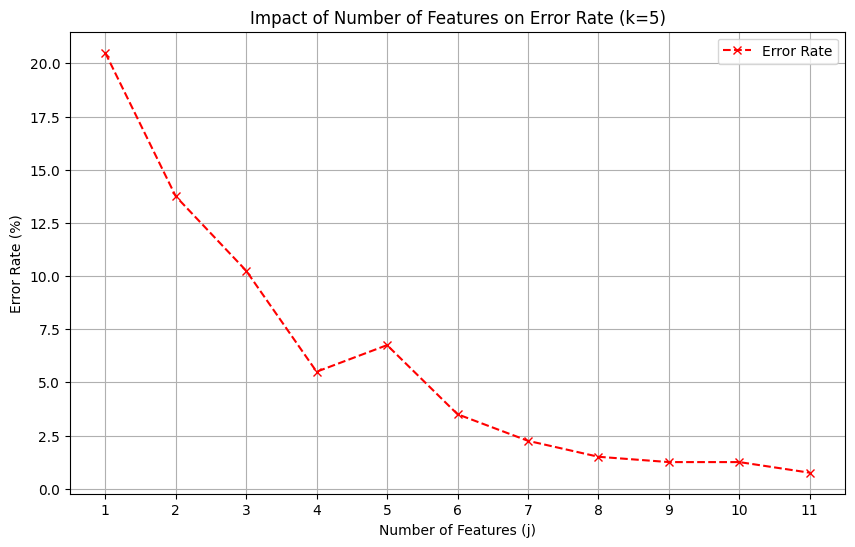

In [ ]:
import csv
import math
import random
from collections import Counter
import matplotlib.pyplot as plt

class KNNClassifier:
    """
    A K-Nearest Neighbors classifier implementation that supports multiple distance metrics
    and data normalization.
    """

    def __init__(self, k=5, metric='euclidean'):
        """
        Initializes the KNNClassifier.

        Args:
            k (int): The number of neighbors to use for classification.
            metric (str): The distance metric to use ('euclidean' or 'jaccard').
        """
        if k <= 0:
            raise ValueError("k must be a positive integer.")
        if metric not in ['euclidean', 'jaccard']:
            raise ValueError("Metric must be either 'euclidean' or 'jaccard'.")

        self.k = k
        self.metric = metric
        self.X_train = []
        self.y_train = []

        # Internal state for normalization
        self._is_normalized = False
        self._min_max = []

    def _euclidean_distance(self, p1, p2):
        """Calculates the Euclidean distance between two numeric points."""
        return math.sqrt(sum((e1 - e2)**2 for e1, e2 in zip(p1, p2)))

    def _jaccard_distance(self, p1, p2):
        """Calculates the Jaccard distance between two categorical points."""
        set1 = set(p1)
        set2 = set(p2)
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return 1 - (intersection / union) if union != 0 else 0

    def train(self, training_data):
        """
        Trains the model by loading and storing the data.
        Converts features to float for Euclidean, keeps as-is for Jaccard.
        """
        if not training_data:
            print("Warning: The provided training data is empty.")
            return

        self.X_train = []
        self.y_train = []

        # --- Error Handling for Malformed Input ---
        # This loop skips any row that cannot be processed correctly.
        for row in training_data:
            try:
                features = row[:-1]
                if not features or not row[-1]: # Check for empty features or label
                    print(f"Warning: Skipping row with missing values: {row}")
                    continue

                # For Euclidean distance, features must be numeric
                if self.metric == 'euclidean':
                    features = [float(x) for x in features]

                self.X_train.append(features)
                self.y_train.append(row[-1].strip())
            except (ValueError, IndexError):
                print(f"Warning: Skipping malformed row that could not be processed: {row}")
                continue

        if not self.X_train:
            raise ValueError("No valid data was loaded for training. Please check the input file.")

        # --- Error Handling for Fewer than k items ---
        # Checks if the number of valid training samples is less than k.
        if len(self.X_train) < self.k:
            print(f"CRITICAL WARNING: The number of valid training samples ({len(self.X_train)}) is less than k ({self.k}).")
            print("The model will use all available samples for prediction, but results may be unreliable.")


    def normalize_data(self):
        """
        Applies min-max normalization to the loaded training data.
        This method should only be used with Euclidean distance.
        """
        if self.metric != 'euclidean':
            print("Warning: Normalization is only applicable for the 'euclidean' metric.")
            return

        if not self.X_train:
            raise RuntimeError("Must train the model before normalizing data.")

        self._min_max = []
        num_features = len(self.X_train[0])
        for i in range(num_features):
            col = [row[i] for row in self.X_train]
            min_val, max_val = min(col), max(col)
            self._min_max.append((min_val, max_val))

        for i, row in enumerate(self.X_train):
            normalized_row = []
            for j, val in enumerate(row):
                min_v, max_v = self._min_max[j]
                if (max_v - min_v) == 0:
                    normalized_row.append(0)
                else:
                    normalized_row.append((val - min_v) / (max_v - min_v))
            self.X_train[i] = normalized_row

        self._is_normalized = True
        print("Training data has been normalized.")

    def predict(self, new_data):
        """Predicts the class for a list of new data points."""
        if not self.X_train:
            raise RuntimeError("Classifier has not been trained. Call train() first.")

        distance_func = self._euclidean_distance if self.metric == 'euclidean' else self._jaccard_distance

        processed_data = []
        for row in new_data:
            p_row = row
            if self.metric == 'euclidean':
                p_row = [float(x) for x in p_row]
                if self._is_normalized:
                    normalized_row = []
                    for i, val in enumerate(p_row):
                        min_v, max_v = self._min_max[i]
                        if (max_v - min_v) == 0:
                            normalized_row.append(0)
                        else:
                            normalized_row.append((val - min_v) / (max_v - min_v))
                    p_row = normalized_row
            processed_data.append(p_row)

        predictions = []
        for test_row in processed_data:
            distances = [(self.y_train[i], distance_func(test_row, train_row)) for i, train_row in enumerate(self.X_train)]
            distances.sort(key=lambda x: x[1])

            # Use min(self.k, len(self.X_train)) to avoid errors if k > num_samples
            num_neighbors = min(self.k, len(self.X_train))
            neighbors = [dist[0] for dist in distances[:num_neighbors]]

            if not neighbors:
                predictions.append(None) # Should not happen if train data exists
                continue

            most_common = Counter(neighbors).most_common(1)
            predictions.append(most_common[0][0])

        return predictions

def evaluate_k_impact(full_dataset):
    """
    Tests different values of k and plots the accuracy and error rate on separate graphs.
    """
    print("\n--- Evaluating Impact of k ---")
    k_values = range(1, 22, 2) # Test k = 1, 3, 5, ..., 21
    accuracies = []
    error_rates = []

    for k in k_values:
        random.shuffle(full_dataset)
        split_index = int(len(full_dataset) * 0.80)
        training_set = full_dataset[:split_index]
        testing_set = full_dataset[split_index:]

        X_test = [row[:-1] for row in testing_set]
        y_test = [row[-1].strip() for row in testing_set]

        classifier = KNNClassifier(k=k, metric='euclidean')
        classifier.train(training_set)
        classifier.normalize_data()
        predictions = classifier.predict(X_test)

        correct = sum(1 for i in range(len(predictions)) if predictions[i] == y_test[i])
        accuracy = (correct / len(testing_set)) * 100 if testing_set else 0
        error_rate = 100 - accuracy

        accuracies.append(accuracy)
        error_rates.append(error_rate)
        print(f"k={k}: Accuracy={accuracy:.2f}%, Error Rate={error_rate:.2f}%")

    # Plot 1: Accuracy vs. k
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, marker='o', linestyle='-', label='Accuracy')
    plt.title('Impact of k on Classifier Accuracy')
    plt.xlabel('Value of k (Number of Neighbors)')
    plt.ylabel('Accuracy (%)')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()

    # Plot 2: Error Rate vs. k
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, error_rates, marker='x', linestyle='--', color='r', label='Error Rate')
    plt.title('Impact of k on Classifier Error Rate')
    plt.xlabel('Value of k (Number of Neighbors)')
    plt.ylabel('Error Rate (%)')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()

    plt.show()

def evaluate_j_impact(full_dataset):
    """
    Tests different numbers of features (j) and plots the accuracy and error rate on separate graphs.
    """
    print("\n--- Evaluating Impact of Number of Features (j) ---")
    if not full_dataset: return

    max_features = len(full_dataset[0]) - 1
    feature_counts = range(1, max_features + 1)
    accuracies = []
    error_rates = []

    for j in feature_counts:
        dataset_subset = [row[:j] + [row[-1]] for row in full_dataset]

        random.shuffle(dataset_subset)
        split_index = int(len(dataset_subset) * 0.80)
        training_set = dataset_subset[:split_index]
        testing_set = dataset_subset[split_index:]

        X_test = [row[:-1] for row in testing_set]
        y_test = [row[-1].strip() for row in testing_set]

        classifier = KNNClassifier(k=5, metric='euclidean')
        classifier.train(training_set)
        classifier.normalize_data()
        predictions = classifier.predict(X_test)

        correct = sum(1 for i in range(len(predictions)) if predictions[i] == y_test[i])
        accuracy = (correct / len(testing_set)) * 100 if testing_set else 0
        error_rate = 100 - accuracy

        accuracies.append(accuracy)
        error_rates.append(error_rate)
        print(f"j={j} features: Accuracy={accuracy:.2f}%, Error Rate={error_rate:.2f}%")

    # Plot 1: Accuracy vs. j
    plt.figure(figsize=(10, 6))
    plt.plot(feature_counts, accuracies, marker='o', linestyle='-', label='Accuracy')
    plt.title('Impact of Number of Features on Accuracy (k=5)')
    plt.xlabel('Number of Features (j)')
    plt.ylabel('Accuracy (%)')
    plt.xticks(feature_counts)
    plt.grid(True)
    plt.legend()

    # Plot 2: Error Rate vs. j
    plt.figure(figsize=(10, 6))
    plt.plot(feature_counts, error_rates, marker='x', linestyle='--', color='r', label='Error Rate')
    plt.title('Impact of Number of Features on Error Rate (k=5)')
    plt.xlabel('Number of Features (j)')
    plt.ylabel('Error Rate (%)')
    plt.xticks(feature_counts)
    plt.grid(True)
    plt.legend()

    plt.show()

# --- Example Usage ---
if __name__ == '__main__':

    filepath = "Prog1data.csv"

    try:
        with open(filepath, 'r') as f:
            full_dataset = [row for row in csv.reader(f) if row]
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        full_dataset = []

    if full_dataset:
        # Run the analyses to generate plots
        evaluate_k_impact(full_dataset)
        evaluate_j_impact(full_dataset)
    else:
        print("Could not run analysis because the dataset is empty or not found.")
